# Loading LID Artifacts

In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from dotenv import load_dotenv
from PIL import Image

import notebook_setup


artifact_path = './outputs/hamid-exps/{subpath}/artifacts/'
artifact_subpath = {
    'mnist': '73739566779c4855b9ea269c83de198d',
    'fmnist': '785f06205a7b45748baf2aaffa6faac4',
    'svhn': '6702883d01c94836bed77794baf5b5ae',
    'cifar10': '1fd4b791441242eca985fb0906991f04',
}


Set up your .env to contain `<DATASET>_EXP_ROOT` variables pointing to the `artifacts` directories for your `mnist`, `fmnist`, `svhn`, and `cifar10` experiments.

Load the "trend" CSVs from the artifacts directory and the images for which they were computed.

In [ ]:
def get_trend_df(dataset):
    artifact_dir = Path(artifact_path.format(subpath=artifact_subpath[dataset]))
    lid_trend_path = artifact_dir / 'lid_logs_FlipdEstimator/trends/trend_epoch=0001.csv'
    if not lid_trend_path.exists():: # Sometimes the paths are inconsistent
        lid_trend_path = artifact_dir / 'FlipdEstimator/trends/trend_epoch=0001.csv'

    return pd.read_csv(lid_trend_path, index_col=0)


def get_imgs(dataset):
    artifact_dir = Path(artifact_path.format(subpath=artifact_subpath[dataset]))
    img_dir = artifact_dir / 'lid_logs_FlipdEstimator/samples'
    if not img_dir.exists()
        img_dir = artifact_dir / 'FlipdEstimator/samples'
    img_paths = list(img_dir.glob('idx=*_transformed.png'))
    img_paths.sort()

    pils = []
    for path in img_paths:
        with Image.open(path) as img:
            pils.append(img.copy())
        
    return pils


trend_df = {
    dataset: get_trend_df(dataset) for dataset, hyper_paths in artifact_subpath.items()
}
img_pils = {
    dataset: get_imgs(dataset) for dataset, _ in artifact_subpath.items()
}

# Computing PNG Sizes

For every image, add PNG compression size along with the LIDs loaded above to a new dataframe

In [3]:
import cv2


def png_size(img, compression_level=9):
    arr = np.array(img)
    img_encoded = cv2.imencode('.png', arr, [int(cv2.IMWRITE_PNG_COMPRESSION), compression_level])    
    return 8.0 * len(img_encoded[1])


png_sizes = {
    dataset: pd.Series([png_size(img) for img in pils], name='png size')
    for dataset, pils in img_pils.items()
}

In [4]:
comparison_df = {
    key: df.merge(png_sizes[key], left_index=True, right_index=True)
    for key, df in trend_df.items()
}

# Computing (Model-Free) LIDS

Estimate model-free LIDs for each dataset and add them to that dataset's `comparison_df`.

In [49]:
import pickle

import torch
from torchvision import transforms

from lid.skdim import SkdimLIDEstimator


def get_lid_estimator(images, ambient_dim, estimator_type, n_neighbors):
    load_kwargs = {
        'path': dataset,
        'split': 'train',
    }

    # Special cases
    if dataset == 'fmnist':
        load_kwargs['path'] = 'fashion_mnist'
    elif dataset == 'svhn':
        load_kwargs['name'] = 'cropped_digits'
        
    transform = transforms.ToTensor()
    data = torch.stack([transform(img) for img in images])
    
    lid_estimator = SkdimLIDEstimator(
        data, 
        ambient_dim=ambient_dim, 
        estimator_type=estimator_type,
    )
    lid_estimator.fit(n_neighbors=n_neighbors)

    return lid_estimator


lid_estimators = {}

for n_neighbors in (100, 1000):
    lid_estimators[n_neighbors] = {}
    
    for estimator_type in ('ESS', 'lPCA'):
        print(f'Computing {estimator_type} estimates')
        lid_estimators[n_neighbors][estimator_type] = {}

        for dataset, adim in ('mnist', 28*28), ('fmnist', 28*28), ('svhn', 32*32*3), ('cifar10', 32*32*3):
            print(f'\tComputing {dataset} LIDs')
            lid_estimators[n_neighbors][estimator_type][dataset] = get_lid_estimator(
                img_pils[dataset], adim, estimator_type, n_neighbors)

    # Cache the LID estimators if desired
#    with open('lid_estimators.pkl', 'wb') as f:
#        pickle.dump(lid_estimators, f)
        
for dataset in ('mnist', 'fmnist', 'svhn', 'cifar10'):
    for n_neighbors in (100, 1000):
        for estimator in ('ESS', 'lPCA'):
            comparison_df[dataset][f'{estimator}_{n_neighbors}'] = (
                lid_estimators[n_neighbors][estimator][dataset]._lid)

# Analysis

Note that sample complexity of the trace estimate appears to rise with the timestep. For `timestep = 2`, single-sample Hutchinson estimates are strongly correlated with the deterministic estimate, while with `timestep = 10`, the correlation is much weaker.

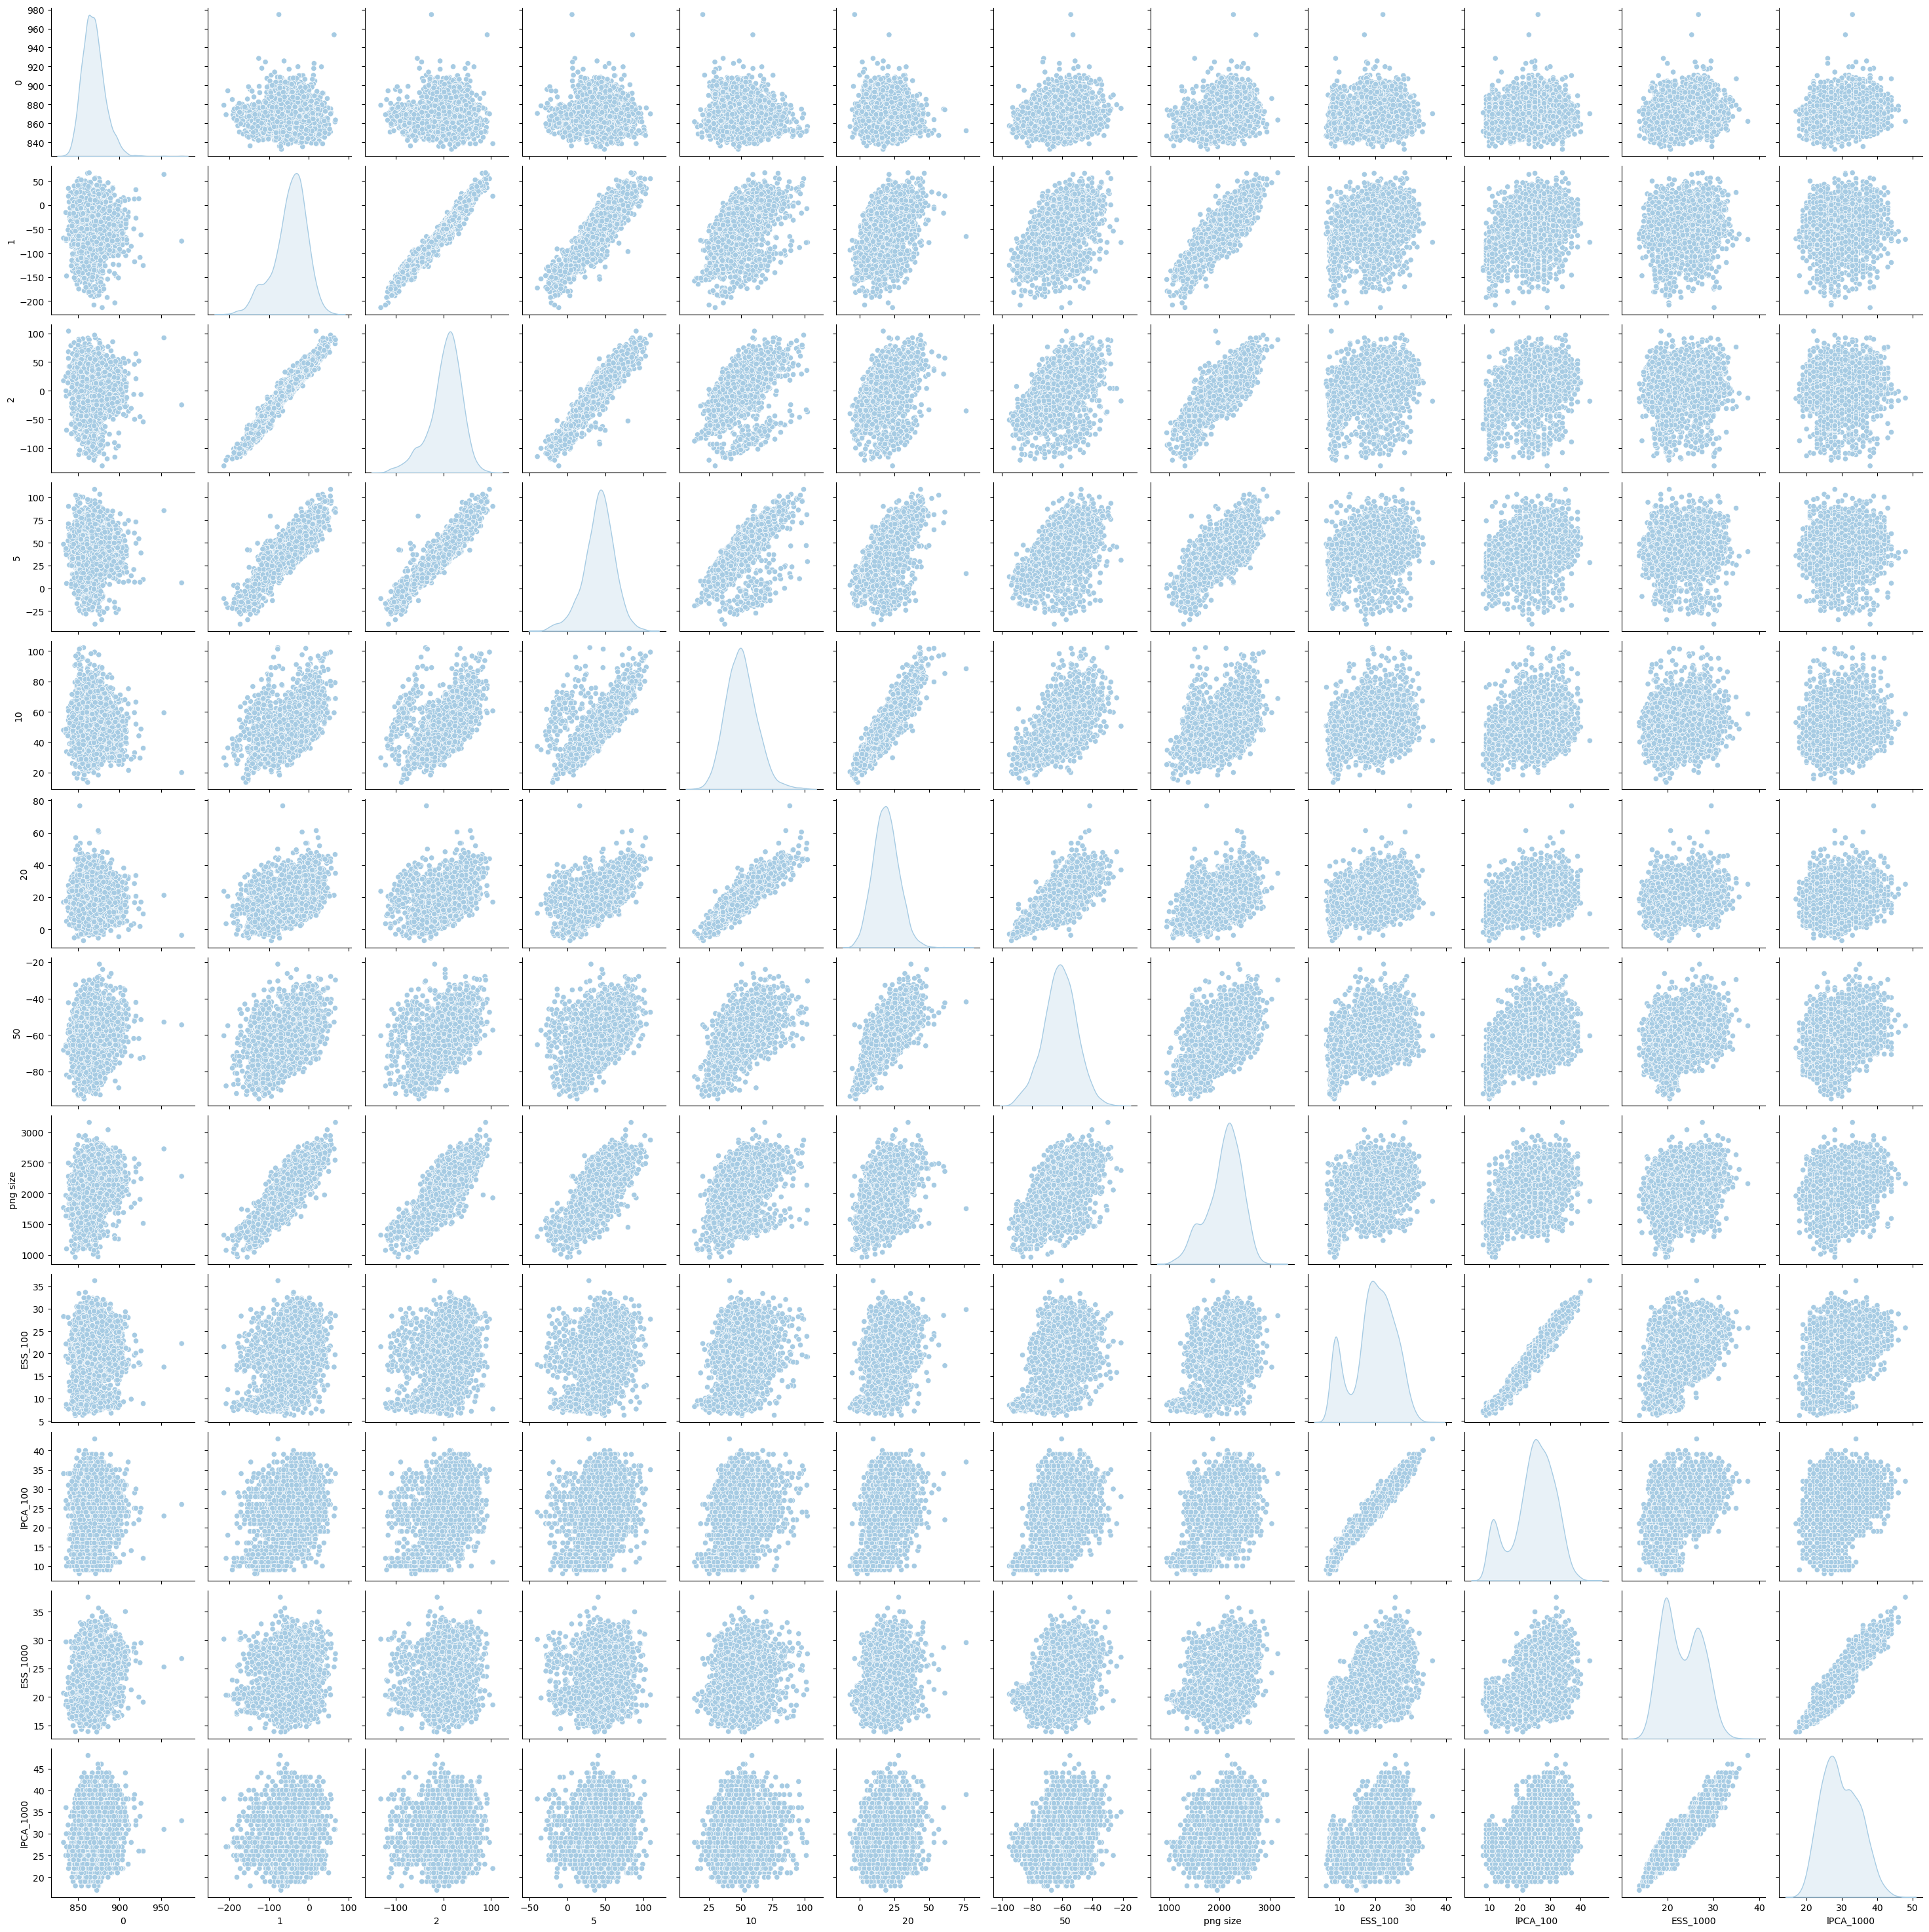

In [105]:
import seaborn as sns

from visualization.pretty import ColorTheme



dataset = 'mnist'
cols = ['0', '1', '2', '5', '10', '20', '50', 'png size', 'ESS_100', 'lPCA_100', 'ESS_1000', 'lPCA_1000']

comparison_df[dataset]['hue'] = 'dummy'
palette = {'dummy': ColorTheme.get_colors(1)[0]}

g = sns.pairplot(comparison_df[dataset], vars=cols, hue='hue', palette=palette)
g._legend.remove()

comparison_df[dataset].drop(columns='hue', inplace=True)

### Comparing image orderings

In [ ]:
from visualization import image_grid

# Specify the dataset and size of random subsample to observe
indices = np.sort(np.random.choice(4096, size=4096, replace=False))
dataset = 'mnist'


def lid_id_ordering(dataset, timestep):
    return comparison_df[dataset][timestep].loc[indices].sort_values().index
    

def view_samples_by_lid(dataset, timestep, cols=40):
    return image_grid(
        [img_pils[dataset][i] 
         for i in lid_id_ordering(dataset, timestep)], cols=cols)    


def stack_imgs(imgs):
    stack_gap = 32
    
    height = sum(img.height + stack_gap for img in imgs)
    width = imgs[0].width
    stacked_img = Image.new("RGB", (width, height))
    
    current_y = 0
    for img in imgs:
        stacked_img.paste(img, (0, current_y))
        current_y += img.height + stack_gap
    return stacked_img


    
ranked_imgs = [
    view_samples_by_lid(
        dataset=dataset,
        timestep=col,
    ) for col in ['5', '50', 'png size', 'ESS_100', 'ESS_1000']
]

# Uncomment the `.save` method to save the grids to disk
stack_imgs(ranked_imgs)#.save('cifar_orderings.png')